In [52]:
from scipy.sparse import hstack, csr_matrix
from tqdm import tqdm
import numpy as np
import pandas as pd
import re

from collections import Counter
from collections import defaultdict
from scipy import sparse
from scipy.stats import uniform

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# Part 1: Representing Text Data

In [53]:
train = pd.read_csv("data/train.csv")
dev = pd.read_csv("data/dev.csv")
test = pd.read_csv("data/test.csv")

## Task 1.1: Tokenization

In [54]:
stopwords = {
    'ourselves', 'hers', 'between', 'yourself', 'but', 'again', 'there', 'about', 
    'once', 'during', 'out', 'very', 'having', 'with', 'they', 'own', 'an', 'be', 
    'some', 'for', 'do', 'its', 'yours', 'such', 'into', 'of', 'most', 'itself', 
    'other', 'off', 'is', 's', 'am', 'or', 'who', 'as', 'from', 'him', 'each', 
    'the', 'themselves', 'until', 'below', 'are', 'we', 'these', 'your', 'his', 
    'through', 'don', 'nor', 'me', 'were', 'her', 'more', 'himself', 'this', 'down', 
    'should', 'our', 'their', 'while', 'above', 'both', 'up', 'to', 'ours', 'had', 
    'she', 'all', 'no', 'when', 'at', 'any', 'before', 'them', 'same', 'and', 
    'been', 'have', 'in', 'will', 'on', 'does', 'yourselves', 'then', 'that', 
    'because', 'what', 'over', 'why', 'so', 'can', 'did', 'not', 'now', 'under', 
    'he', 'you', 'herself', 'has', 'just', 'where', 'too', 'only', 'myself', 
    'which', 'those', 'i', 'after', 'few', 'whom', 't', 'being', 'if', 'theirs', 
    'my', 'against', 'a', 'by', 'doing', 'it', 'how', 'further', 'was', 'here', 'than',
}

punctuations = '''!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~—'''

In [55]:
def tokenize(text):
    # Split the text by whitespace and return the list of tokens
    return text.split()

def better_tokenize(input_str):
    # manipulation
    temp_str = input_str.replace('\n', '')
    temp_str = re.sub(r"\<[^<>]*\>", '', temp_str) # remove hidden names inside <>
    for punc in punctuations:
        temp_str = temp_str.replace(punc, '') # remove punctuations
    token = temp_str.lower().split() # turn into lower cases
    token = [t for t in token if not t in stopwords] # remove stopwords
    return token

In [56]:
input_str = "Your sample text goes here."
tokens = better_tokenize(input_str)
print(tokens)

['sample', 'text', 'goes']


## Task 1.2: Building the Term-Document Matrix

In [57]:
def create_term_dictionary(df, column_name, min_frequency = 2):
    """
    Create a term dictionary with terms meeting the minimum term frequency.

    :param df: DataFrame containing the text data
    :param column_name: The name of the column in the DataFrame containing the text
    :param min_tf: Minimum term frequency threshold
    :param stop_punctuations: List of punctuation marks to be removed
    :param stop_words: List of stop words to be removed
    :return: A dictionary of terms with their frequencies
    """
    all_term_dict = defaultdict(int)

    # Accumulate term frequencies across all documents
    for _, row in df.iterrows():
        tokens = better_tokenize(row[column_name])
        for token in tokens:
            all_term_dict[token] += 1

    # Filter out terms below the minimum term frequency
    term_dict = {term: freq for term, freq in all_term_dict.items() if freq >= min_frequency}

    return term_dict

term_dict = create_term_dictionary(train, "text", 10)

In [58]:
print(f"Number of terms in term_dict is {len(term_dict)}.")

Number of terms in term_dict is 3197.


In [59]:
def CSRMatrixGeneration(docs, vocabulary = {}, termDict = term_dict):
    indptr = [0]
    indices = []
    data = []
    
    print("Generating CSR sparse matrix...")
    for doc in tqdm(docs):
        for term in doc:
            if term in termDict.keys(): # remove term with tf < 10
                index = vocabulary.setdefault(term, len(vocabulary))
                indices.append(index)
                data.append(1)
        indptr.append(len(indices))

    csr_mat = sparse.csr_matrix((data, indices, indptr), dtype=int)
    return csr_mat, vocabulary

In [60]:
# generate doc list
docs = []
print("Generating doc list for train...")
for index, row in tqdm(train.iterrows(), total = train.shape[0]):
    docs.append(better_tokenize(row["text"]))
    
train_mat, train_vocabulary = CSRMatrixGeneration(docs)
train_mat = sparse.hstack([train_mat, np.ones(len(train_mat.toarray()))[:,None]]) # add the bias column
train_mat = sparse.csr_matrix(train_mat)

Generating doc list for train...


100%|██████████| 7328/7328 [00:00<00:00, 16400.81it/s]


Generating CSR sparse matrix...


100%|██████████| 7328/7328 [00:00<00:00, 152801.45it/s]


# Part 2: Logistic Regression in numpy

In [61]:
def sigmoid(X):
    return 1 / (1 + np.exp(-X))

def log_likelihood(X, y, beta):
    sum = 0
    for i in range(X.shape[0]):  # 遍历样本
        x_i = X[i].toarray().flatten()
        sum += y[i] * np.dot(beta, x_i) - np.log10(1 + np.exp(np.dot(beta, x_i)))
    return sum


def compute_gradient(x, y, beta):
    return np.dot((sigmoid(np.dot(beta, x)) - y), x)

In [62]:
def logistic_regression(X, y, learning_rate = 5e-5, num_step = 1000, is_plot = False):
    # INPUT: X is a sparse matrix length doc number D * length V
    # INPUT: y is a 1-d np.array length V
    # OUTPUT: a trained parameter beta length V
    n = len(X[0].toarray().flatten()) # vocabulary (feature) length
    beta = np.zeros(n) # init beta
    prev_ll = log_likelihood(X, y, beta) # for previous log-likelihood, recorded per 100 steps
    if is_plot:
        step_list = []
        ll_list = [] # for log likelihood plot per 100 steps
    
    print("Starting Logistic Regression to find the parameter vector beta...")
    for step_count in tqdm(range(num_step)):
        beta = beta - learning_rate * compute_gradient(X[step_count % n].toarray().flatten(), 
                                                       y[step_count % n], 
                                                       beta)
        if step_count % 100 == 0:
            if is_plot:
                step_list.append(step_count)
                ll_list.append(log_likelihood(X, y, beta))
    
    if is_plot:
        return beta, step_list, ll_list
    else:
        return beta

In [63]:
def predict(text, beta, vocab_dict = train_vocabulary):
    x_pred = np.zeros(len(vocab_dict) + 1)
    
    term_dict = Counter(better_tokenize(text))
    for term, freq in term_dict.items():
        if term in vocab_dict.keys():
            x_pred[vocab_dict[term]] = freq
    x_pred[-1] = 1 # bias
    
    y_pred = sigmoid(np.dot(beta, x_pred))
    if y_pred < 0.152:
        return 0
    else:
        return 1

## Task 2.1: Plot log-likelihood

In [64]:
label_dict = {0: 0, 1: 1}
y_train = np.array([label_dict[p] for p in train["label"]])

beta, step_list, ll_list = logistic_regression(X = train_mat,
                                               y = y_train, 
                                               num_step = 10000,
                                               is_plot = True)

Starting Logistic Regression to find the parameter vector beta...


100%|██████████| 10000/10000 [00:40<00:00, 249.71it/s]


Text(0.5, 1.0, 'Loss v.s. Log-likelihood for Full Train Data')

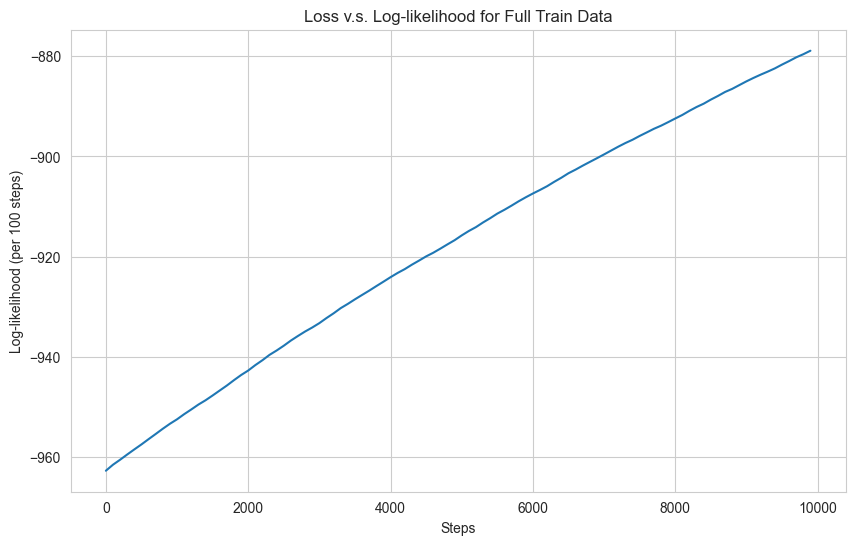

In [65]:
# plot the step v.s. log-likelihood
plt.figure(figsize=(10,6))
ax = sns.lineplot(x = step_list, y = ll_list)
ax.set(xlabel="Steps", ylabel = "Log-likelihood (per 100 steps)")
ax.set_title("Loss v.s. Log-likelihood for Full Train Data")

## Task 2.2: Make prediction on validation dataset

In [66]:
# train the beta
beta = logistic_regression(X = train_mat,
                           y = y_train, 
                           learning_rate = 5e-5, 
                           num_step = 500000)

Starting Logistic Regression to find the parameter vector beta...


100%|██████████| 500000/500000 [00:33<00:00, 14764.37it/s]


In [67]:
# make prediction
y_test = [label_dict[p] for p in dev["label"]]
y_pred = []
print("Starting prediction on validation dataset...")
for i in tqdm(range(len(dev))):
    y_pred.append(predict(dev["text"][i], beta))


Starting prediction on validation dataset...


100%|██████████| 1047/1047 [00:00<00:00, 34715.46it/s]


In [68]:
# compute f1score
from sklearn.metrics import f1_score
f1_score(y_test, y_pred)

0.3626373626373627

## Task 2.3: Make prediction on test dataset

In [69]:
rev_label_dict = {0: 0, 1: 1}

# make prediction
y_pred = []
print("Starting prediction on test dataset...")
for i in tqdm(range(len(test))):
    text = test["text"][i]
    if not isinstance(text, str):
        text = str(text)
    y_pred.append(predict(text, beta))

    
result = pd.DataFrame()
result["par_id"] = test["par_id"]
result["label"] = [rev_label_dict[p] for p in y_pred]
# output result
result.to_csv("part2_result.csv", index=False)

Starting prediction on test dataset...


100%|██████████| 2094/2094 [00:00<00:00, 32632.13it/s]


# Part 3: Logistic Regression in PyTorch

In [70]:
# ignore the installation command if torch has been installed
# ! pip3 install torch torchvision torchaudio
import torch
import torch.nn as nn

In [71]:
def to_sparse_tensor(np_sparse_mat):
    # INPUT: a numpy sprase matrix used previously
    # OUTPUT: a torch sparse matrix
    coo_mat = np_sparse_mat.tocoo()
    
    values = coo_mat.data
    indices = np.vstack((coo_mat.row, coo_mat.col))
    
    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    shape = coo_mat.shape

    torch_sparse_mat = torch.sparse_coo_tensor(i, v, torch.Size(shape))
    return torch_sparse_mat

train_mat_torch = to_sparse_tensor(train_mat)

In [72]:
class LogisticRegression(nn.Module):
    def __init__(self, input_features: int, output_features: int = 1, bias: bool = True):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_features, output_features, bias)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return self.sigmoid(self.linear(x))

In [73]:
# useless helper function
def GetTensorRow(tensor, i):
    return tensor.index_select(0, torch.tensor([i % len(tensor)])).to_dense()[0]

In [74]:
# dev data preprocessing for prediction
docs = []
print("Generating doc list for dev ...")
for index, row in tqdm(dev.iterrows(), total = dev.shape[0]):
    docs.append(better_tokenize(row["text"]))
    
dev_mat, dev_vocabulary = CSRMatrixGeneration(docs, vocabulary=train_vocabulary)
dev_mat = sparse.hstack([dev_mat, np.zeros(len(dev_mat.toarray()))[:,None]]) # add the missing column
dev_mat = sparse.hstack([dev_mat, np.zeros(len(dev_mat.toarray()))[:,None]]) # add the missing column
dev_mat = sparse.hstack([dev_mat, np.ones(len(dev_mat.toarray()))[:,None]]) # add the bias column
dev_mat = sparse.csr_matrix(dev_mat)

dev_mat_torch = to_sparse_tensor(dev_mat)

Generating doc list for dev ...


100%|██████████| 1047/1047 [00:00<00:00, 15387.44it/s]


Generating CSR sparse matrix...


100%|██████████| 1047/1047 [00:00<00:00, 87216.47it/s]


In [75]:
# given a model, predict on the tensor of new text
def better_predict(x_tensor, model):
    y_pred = model(x_tensor)
    if y_pred < 0.12:
        return 0
    else:
        return 1

In [76]:
# make prediction and get f1 score
dev_mat_torch_dense = dev_mat_torch.to_dense() # set global for quicklier running

def better_GetF1Score(model, dev = dev):
    # require dev_mat_torch as global variable
    y_test = [label_dict[p] for p in dev["label"]]
    y_pred = []
    for i in range(len(dev_mat_torch)):
        y_pred.append(
            better_predict(dev_mat_torch_dense[i], model)
        )
    return f1_score(y_test, y_pred) # compute f1score

In [77]:
train_mat_torch_dense = train_mat_torch.to_dense()  # set global for quicklier running

def TrainModel(X = train_mat_torch_dense, y = y_train, num_epoch = 1, num_step = len(train_mat_torch), \
               opt_choice = 1, learning_rate = 5e-5, l2penalty = 0, \
               isloss = False, isf1score = False):
    # INPUT: X is a torch sparse matrix
    # INPUT: y is a list or np.array of labels
    # OUTPUT: a LR model with trained parameters
    model = LogisticRegression()
    criterion = nn.BCELoss() # loss function
    if opt_choice == 1: # default optimizer
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=l2penalty)
    elif opt_choice == 2:
        optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=l2penalty)
    elif opt_choice == 3:
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=l2penalty)

    # for plotting
    step_list = []
    if isloss:
        loss_list = []
    if isf1score:
        f1score_list = []

    for epoch in range(num_epoch):  # loop over the dataset multiple times
        running_loss = 0.0
        print(f"Starting training in epoch {epoch + 1}...")
        for i in tqdm(range(num_step)):
            # get the inputs and label
            inputs = X[i]
            labels = torch.tensor(y_train[i], dtype=torch.float32).reshape(1)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if (i + 1) % 1000 == 0:
                # print(f'epoch = {epoch + 1}, step = {i} => loss: {running_loss / 1000:.3f}')
                step_list.append(epoch * num_step + i)
                if isloss:
                    loss_list.append(running_loss)
                if isf1score:
                    f1score_list.append(better_GetF1Score(model))
                
                running_loss = 0.0
    
    print('Finished Training')
    
    if isloss and isf1score: 
        return model, step_list, loss_list, f1score_list
    elif isloss and not isf1score:
        return model, step_list, loss_list
    else:
        return model

## Task 3.1: Compute loss and F1score for 5 epochs

In [78]:
# train the model
origin_model, step_list, loss_list = TrainModel(num_epoch=5, isloss=True, isf1score=False)

Starting training in epoch 1...


100%|██████████| 7328/7328 [00:03<00:00, 2380.69it/s]


Starting training in epoch 2...


100%|██████████| 7328/7328 [00:03<00:00, 2432.02it/s]


Starting training in epoch 3...


100%|██████████| 7328/7328 [00:02<00:00, 2544.43it/s]


Starting training in epoch 4...


100%|██████████| 7328/7328 [00:02<00:00, 2457.17it/s]


Starting training in epoch 5...


100%|██████████| 7328/7328 [00:02<00:00, 2511.64it/s]

Finished Training


Text(0.5, 1.0, 'Loss v.s. Step for Default Setting')

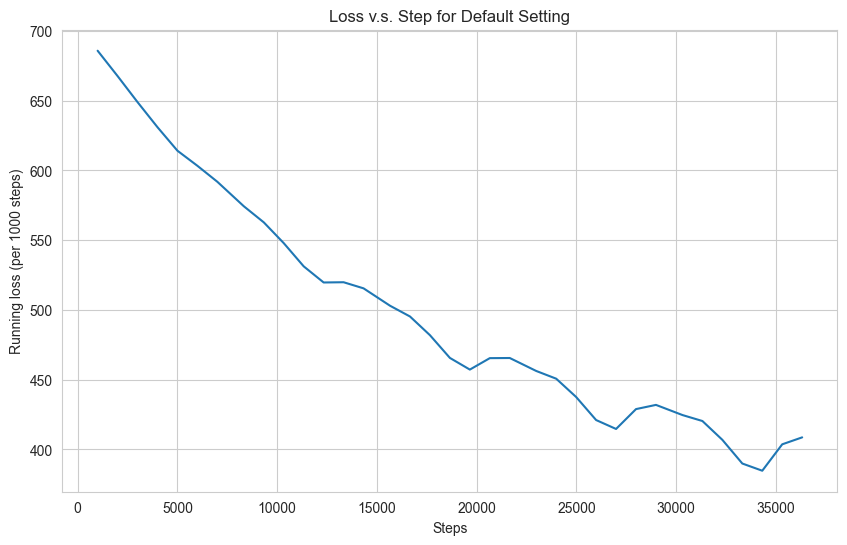

In [79]:
# plot the loss
plt.figure(figsize=(10,6))
ax = sns.lineplot(x = step_list, y = loss_list)
ax.set(xlabel="Steps", ylabel = "Running loss (per 1000 steps)")
ax.set_title("Loss v.s. Step for Default Setting")

In [80]:
f1score = better_GetF1Score(origin_model)
print(f"The F1score of the model after training for 5 epochs is {f1score}")

The F1score of the model after training for 5 epochs is 0.1634446397188049


## Task 3.2: Compute loss and F1score for L2 penalty variations

In [81]:
l2panelty_model1, step_list1, loss_list1, f1score_list1 = \
    TrainModel(l2penalty = 0, isloss=True, isf1score=True)
l2panelty_model2, step_list2, loss_list2, f1score_list2 = \
    TrainModel(l2penalty = 0.001, isloss=True, isf1score=True)
l2panelty_model3, step_list3, loss_list3, f1score_list3 = \
    TrainModel(l2penalty = 0.1, isloss=True, isf1score=True)

Starting training in epoch 1...


100%|██████████| 7328/7328 [00:03<00:00, 2202.56it/s]


Finished Training
Starting training in epoch 1...


100%|██████████| 7328/7328 [00:03<00:00, 2118.81it/s]


Finished Training
Starting training in epoch 1...


100%|██████████| 7328/7328 [00:03<00:00, 2199.28it/s]

Finished Training


In [82]:
# create the dataframe
l2panelty_df = pd.DataFrame({
    "step": step_list1 + step_list2 + step_list3,
    "loss": loss_list1 + loss_list2 + loss_list3,
    "f1score": f1score_list1 + f1score_list2 + f1score_list3,
    "label": [0] * len(step_list1) + [0.001] * len(step_list1) + [0.1] * len(step_list3) 
})

Text(0.5, 1.0, 'Loss v.s. Step for L2 Penalty Variation')

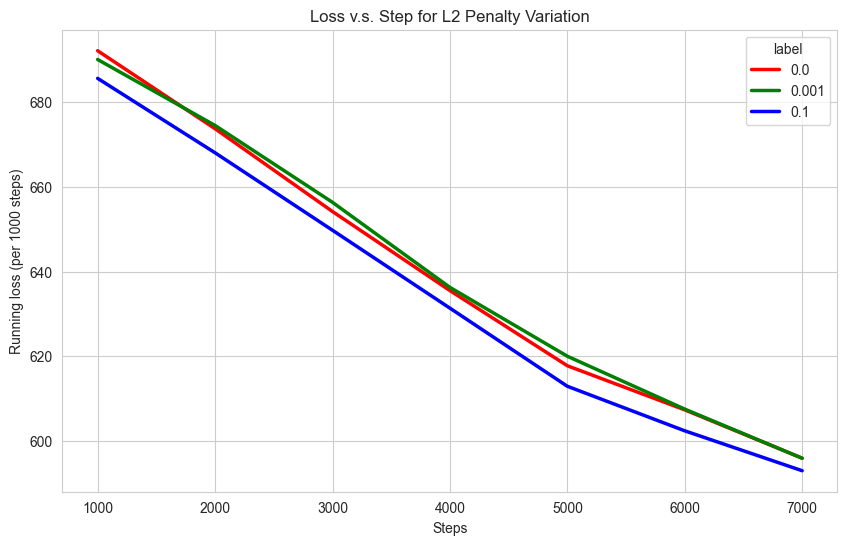

In [83]:
# plot the loss
plt.figure(figsize=(10,6))
ax = sns.lineplot(x="step", y="loss", hue="label", 
                  data=l2panelty_df, palette=['r', 'g', 'b'], linewidth=2.5)
ax.set(xlabel="Steps", ylabel = "Running loss (per 1000 steps)")
ax.set_title("Loss v.s. Step for L2 Penalty Variation")

Text(0.5, 1.0, 'F1score v.s. Step for L2 Penalty Variation')

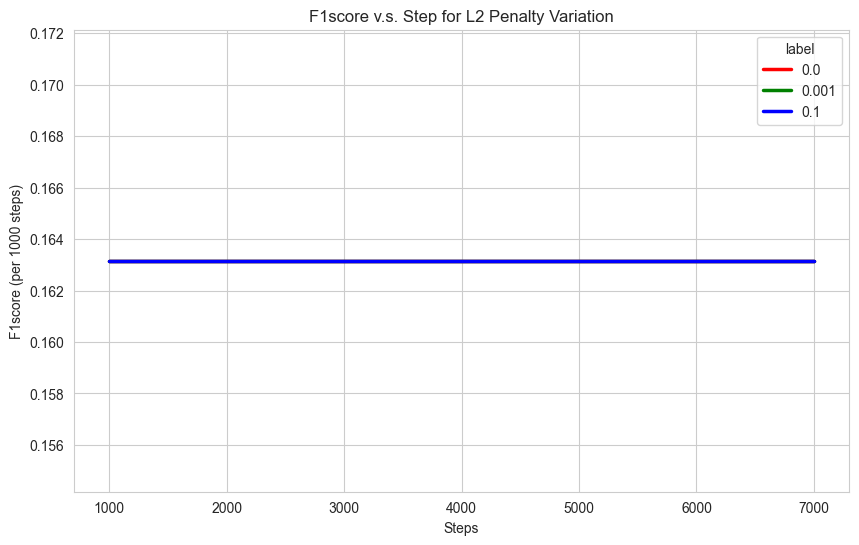

In [84]:
# plot the f1score
plt.figure(figsize=(10,6))
ax = sns.lineplot(x="step", y="f1score", hue="label", 
                  data=l2panelty_df, palette=['r', 'g', 'b'], linewidth=2.5)
ax.set(xlabel="Steps", ylabel = "F1score (per 1000 steps)")
ax.set_title("F1score v.s. Step for L2 Penalty Variation")

## Task 3.3: Compute loss and F1score for optimizer variations

In [85]:
opt_model1, step_list1, loss_list1, f1score_list1 = \
    TrainModel(opt_choice = 1, isloss=True, isf1score=True)
opt_model2, step_list2, loss_list2, f1score_list2 = \
    TrainModel(opt_choice = 2, isloss=True, isf1score=True)
opt_model3, step_list3, loss_list3, f1score_list3 = \
    TrainModel(opt_choice = 3, isloss=True, isf1score=True)

Starting training in epoch 1...


100%|██████████| 7328/7328 [00:03<00:00, 2020.93it/s]


Finished Training
Starting training in epoch 1...


100%|██████████| 7328/7328 [00:04<00:00, 1636.93it/s]


Finished Training
Starting training in epoch 1...


100%|██████████| 7328/7328 [00:05<00:00, 1301.78it/s]

Finished Training


In [86]:
# create the dataframe
opt_df = pd.DataFrame({
    "step": step_list1 + step_list2 + step_list3,
    "loss": loss_list1 + loss_list2 + loss_list3,
    "f1score": f1score_list1 + f1score_list2 + f1score_list3,
    "label": ["SGD"] * len(step_list1) + ["RMSprop"] * len(step_list1) + ["AdamW"] * len(step_list3) 
})

Text(0.5, 1.0, 'Loss v.s. Step for Optimizer Variation')

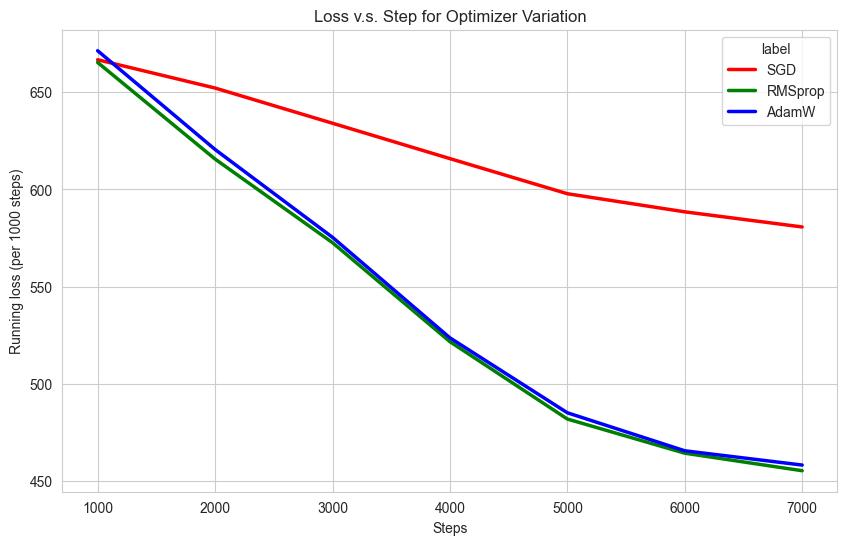

In [87]:
# plot the loss
plt.figure(figsize=(10,6))
ax = sns.lineplot(x="step", y="loss", hue="label", 
                  data=opt_df, palette=['r', 'g', 'b'], linewidth=2.5)
ax.set(xlabel="Steps", ylabel = "Running loss (per 1000 steps)")
ax.set_title("Loss v.s. Step for Optimizer Variation")

Text(0.5, 1.0, 'F1score v.s. Step for Optimizer Variation')

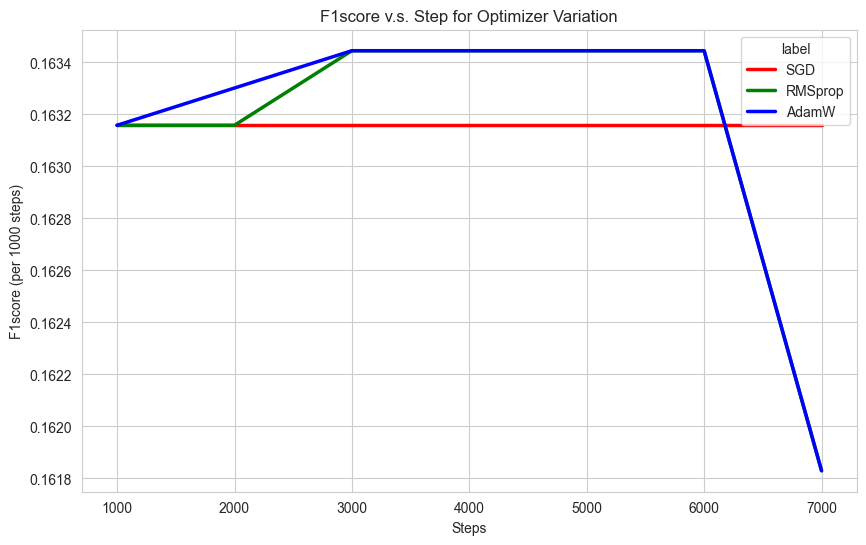

In [88]:
# plot the f1score
plt.figure(figsize=(10,6))
ax = sns.lineplot(x="step", y="f1score", hue="label", 
                  data=opt_df, palette=['r', 'g', 'b'], linewidth=2.5)
ax.set(xlabel="Steps", ylabel = "F1score (per 1000 steps)")
ax.set_title("F1score v.s. Step for Optimizer Variation")

## Task 3.4: Compute loss and F1score for tokenization variations

In [89]:
# See additional file tokenize_variation.ipynb for this task
# the data for tokenize is from the result of tokenize_variation.ipynb
tokenize_model2, step_list2, loss_list2, f1score_list2 = TrainModel(isloss=True, isf1score=True)

Starting training in epoch 1...


100%|██████████| 7328/7328 [00:03<00:00, 2258.23it/s]

Finished Training


In [90]:
# save data to file for main file
tokenize_data_df1 = pd.DataFrame({
    "step": step_list1,
    "loss": loss_list1,
    "f1score": f1score_list1,
    "label": "Worse"
})

tokenize_data_df1.to_csv("tokenize_data.csv", index=False)

In [91]:
# create the dataframe
tokenize_data_df1 = pd.read_csv("tokenize_data.csv")
tokenize_data_df2 = pd.DataFrame({
    "step": step_list2,
    "loss": loss_list2,
    "f1score": f1score_list2,
    "label": "Better"
})
tokenize_df = pd.concat([tokenize_data_df1, tokenize_data_df2]).reset_index()

In [92]:
tokenize_df

,index,step,loss,f1score,label
0,0,999,666.727950,0.163158,Worse
1,1,1999,652.176228,0.163158,Worse
2,2,2999,634.073115,0.163158,Worse
3,3,3999,615.883035,0.163158,Worse
4,4,4999,597.830429,0.163158,Worse
5,5,5999,588.514538,0.163158,Worse
6,6,6999,580.738385,0.163158,Worse
7,0,999,670.090063,0.163158,Better
8,1,1999,652.135944,0.163158,Better
9,2,2999,636.361948,0.163158,Better


Text(0.5, 1.0, 'Loss v.s. Step for Tokenize Variation')

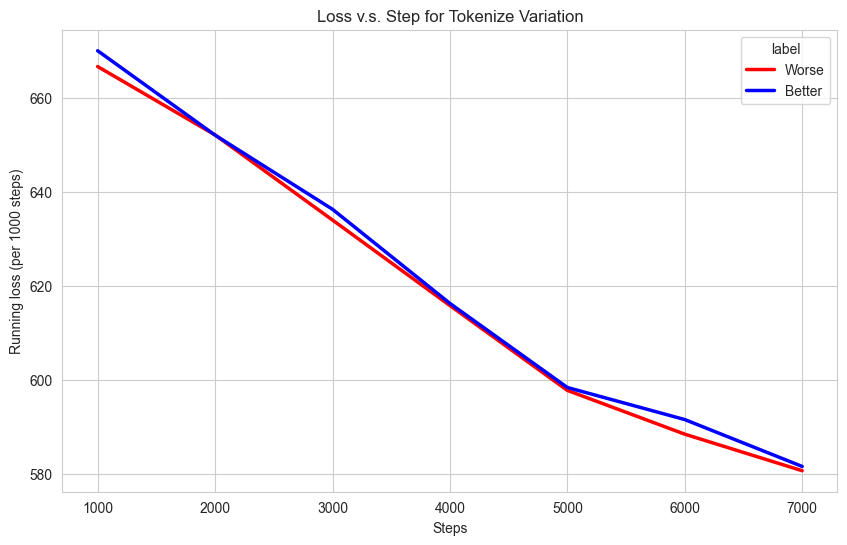

In [93]:
# plot the loss
plt.figure(figsize=(10,6))
ax = sns.lineplot(x="step", y="loss", hue="label", 
                  data=tokenize_df, palette=['r', 'b'], linewidth=2.5)
ax.set(xlabel="Steps", ylabel = "Running loss (per 1000 steps)")
ax.set_title("Loss v.s. Step for Tokenize Variation")

Text(0.5, 1.0, 'F1score v.s. Step for Tokenize Variation')

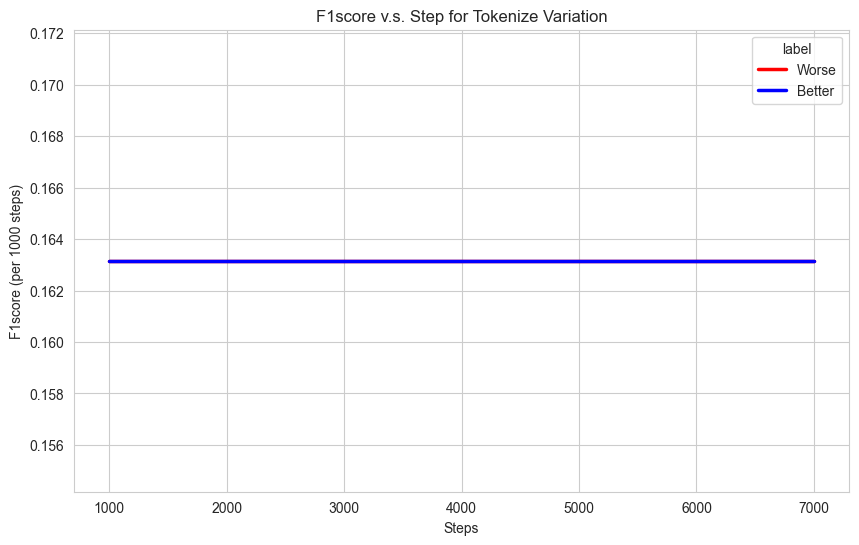

In [94]:
# plot the f1score
plt.figure(figsize=(10,6))
ax = sns.lineplot(x="step", y="f1score", hue="label", 
                  data=tokenize_df, palette=['r',  'b'], linewidth=2.5)
ax.set(xlabel="Steps", ylabel = "F1score (per 1000 steps)")
ax.set_title("F1score v.s. Step for Tokenize Variation")

## Task 3.5: Compute loss and F1score for learning rate variations

In [95]:
lr_model1, step_list1, loss_list1, f1score_list1 = \
    TrainModel(learning_rate=5e-2, isloss=True, isf1score=True)
lr_model2, step_list2, loss_list2, f1score_list2 = \
    TrainModel(learning_rate=5e-5, isloss=True, isf1score=True)
lr_model3, step_list3, loss_list3, f1score_list3 = \
    TrainModel(learning_rate=5e-8, isloss=True, isf1score=True)

Starting training in epoch 1...


100%|██████████| 7328/7328 [00:03<00:00, 2149.79it/s]


Finished Training
Starting training in epoch 1...


100%|██████████| 7328/7328 [00:03<00:00, 2076.84it/s]


Finished Training
Starting training in epoch 1...


100%|██████████| 7328/7328 [00:03<00:00, 2068.85it/s]

Finished Training


In [96]:
# create the dataframe
lr_df = pd.DataFrame({
    "step": step_list1 + step_list2 + step_list3,
    "loss": loss_list1 + loss_list2 + loss_list3,
    "f1score": f1score_list1 + f1score_list2 + f1score_list3,
    "label": ["5e-2"] * len(step_list1) + ["5e-5"] * len(step_list1) + ["5e-8"] * len(step_list3) 
})

Text(0.5, 1.0, 'Loss v.s. Step for Learning Rate Variation')

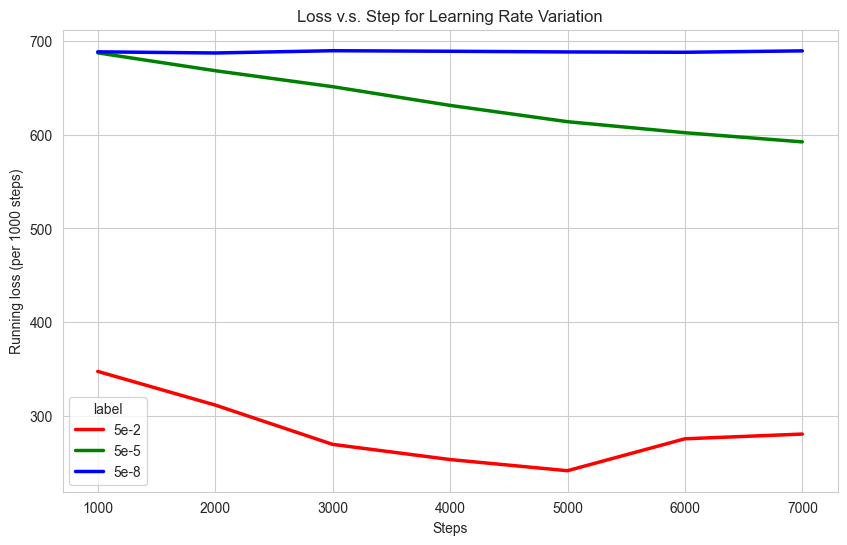

In [97]:
# plot the loss
plt.figure(figsize=(10,6))
ax = sns.lineplot(x="step", y="loss", hue="label", 
                  data=lr_df, palette=['r', 'g', 'b'], linewidth=2.5)
ax.set(xlabel="Steps", ylabel = "Running loss (per 1000 steps)")
ax.set_title("Loss v.s. Step for Learning Rate Variation")

Text(0.5, 1.0, 'F1score v.s. Step for Learning Rate Variation')

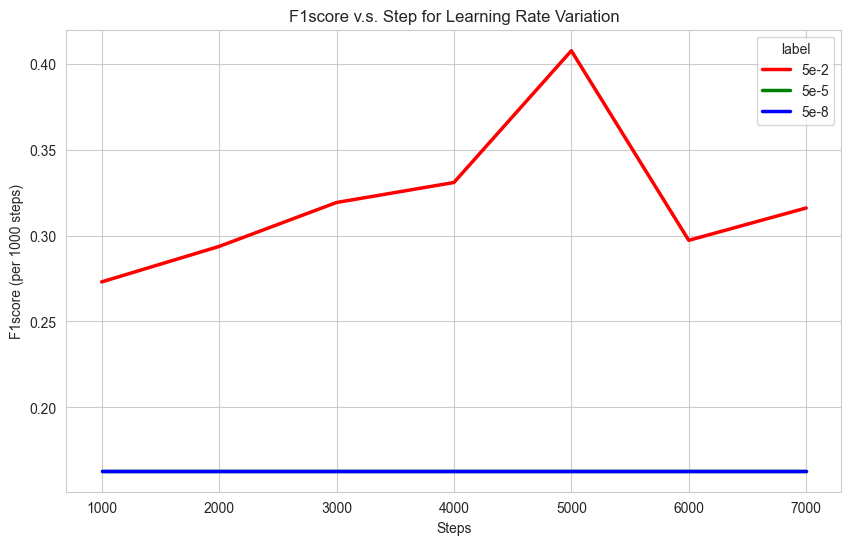

In [98]:
# plot the f1score
plt.figure(figsize=(10,6))
ax = sns.lineplot(x="step", y="f1score", hue="label", 
                  data=lr_df, palette=['r', 'g', 'b'], linewidth=2.5)
ax.set(xlabel="Steps", ylabel = "F1score (per 1000 steps)")
ax.set_title("F1score v.s. Step for Learning Rate Variation")

## Task 3.6: Make prediction on test dataset

In [99]:
# train the best model
best_model = TrainModel(num_epoch = 20, 
                        opt_choice = 3, 
                        learning_rate = 5e-5, 
                        l2penalty = 0)

Starting training in epoch 1...


100%|██████████| 7328/7328 [00:04<00:00, 1494.54it/s]


Starting training in epoch 2...


100%|██████████| 7328/7328 [00:04<00:00, 1486.20it/s]


Starting training in epoch 3...


100%|██████████| 7328/7328 [00:05<00:00, 1457.55it/s]


Starting training in epoch 4...


100%|██████████| 7328/7328 [00:05<00:00, 1464.13it/s]


Starting training in epoch 5...


100%|██████████| 7328/7328 [00:05<00:00, 1437.67it/s]


Starting training in epoch 6...


100%|██████████| 7328/7328 [00:04<00:00, 1514.25it/s]


Starting training in epoch 7...


100%|██████████| 7328/7328 [00:05<00:00, 1426.10it/s]


Starting training in epoch 8...


100%|██████████| 7328/7328 [00:05<00:00, 1363.80it/s]


Starting training in epoch 9...


100%|██████████| 7328/7328 [00:05<00:00, 1248.41it/s]


Starting training in epoch 10...


100%|██████████| 7328/7328 [00:05<00:00, 1320.66it/s]


Starting training in epoch 11...


100%|██████████| 7328/7328 [00:05<00:00, 1238.29it/s]


Starting training in epoch 12...


100%|██████████| 7328/7328 [00:05<00:00, 1310.12it/s]


Starting training in epoch 13...


100%|██████████| 7328/7328 [00:05<00:00, 1284.24it/s]


Starting training in epoch 14...


100%|██████████| 7328/7328 [00:05<00:00, 1312.50it/s]


Starting training in epoch 15...


100%|██████████| 7328/7328 [00:05<00:00, 1248.82it/s]


Starting training in epoch 16...


100%|██████████| 7328/7328 [00:05<00:00, 1263.05it/s]


Starting training in epoch 17...


100%|██████████| 7328/7328 [00:05<00:00, 1239.08it/s]


Starting training in epoch 18...


100%|██████████| 7328/7328 [00:06<00:00, 1186.60it/s]


Starting training in epoch 19...


100%|██████████| 7328/7328 [00:05<00:00, 1247.75it/s]


Starting training in epoch 20...


100%|██████████| 7328/7328 [00:06<00:00, 1201.07it/s]

Finished Training


In [100]:
f1score = better_GetF1Score(best_model)
print(f"The F1score of the best model after training for 5 epochs is {f1score}")

The F1score of the best model after training for 5 epochs is 0.29573934837092736


In [101]:
# test data preprocessing for prediction
docs = []
print("Generating doc list for test ...")
for index, row in tqdm(test.iterrows(), total = test.shape[0]):
    text = row["text"]
    if not isinstance(text, str):
        text = str(text)
    docs.append(better_tokenize(text))
  
test_mat, test_vocabulary = CSRMatrixGeneration(docs, vocabulary=train_vocabulary)
test_mat = sparse.hstack([test_mat, np.ones(test_mat.shape[0])[:,None]]) # add the bias column
test_mat = sparse.hstack([test_mat, np.zeros(len(test_mat.toarray()))[:,None]]) # add the missing column
test_mat = sparse.hstack([test_mat, np.ones(len(test_mat.toarray()))[:,None]]) # add the bias column
test_mat = sparse.csr_matrix(test_mat)

test_mat_torch = to_sparse_tensor(test_mat)
test_mat_torch_dense = test_mat_torch.to_dense()

Generating doc list for test ...


100%|██████████| 2094/2094 [00:00<00:00, 14414.98it/s]


Generating CSR sparse matrix...


100%|██████████| 2094/2094 [00:00<00:00, 146988.76it/s]


In [102]:
rev_label_dict = {0: 0, 1: 1}

# make prediction
y_pred = []
print("Starting prediction on test dataset...")
for i in tqdm(range(len(test_mat_torch_dense))):
    y_pred.append(better_predict(test_mat_torch_dense[i], best_model))
    
result = pd.DataFrame()
result["par_id"] = test["par_id"]
result["label"] = [rev_label_dict[p] for p in y_pred]

# output result
result.to_csv("part3_result.csv", index=False)

Starting prediction on test dataset...


100%|██████████| 2094/2094 [00:00<00:00, 13483.57it/s]
